In [15]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost plotly


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px


In [17]:
# Load parquet files
sales_df = pd.read_parquet("./Data/processed_sales_data.parquet")
print("Sales Data:", sales_df.shape)

sales_df.head()


Sales Data: (730000, 14)


,sale_date,region_id,region_name,medicine_id,medicine_name,medicine_category,daily_sales_quantity,unit_price,population,avg_income,urban_rural_ratio,season,is_weekday,is_holiday
0,2023-01-01,2006,Robbinsland,1041,Vitamin_Thought,Vitamin,68,75.0,3667116,378401,0.68,Winter,False,False
1,2023-01-02,2006,Robbinsland,1041,Vitamin_Thought,Vitamin,106,75.0,3667116,378401,0.68,Winter,True,False
2,2023-01-03,2006,Robbinsland,1041,Vitamin_Thought,Vitamin,93,75.0,3667116,378401,0.68,Winter,True,False
3,2023-01-04,2006,Robbinsland,1041,Vitamin_Thought,Vitamin,98,75.0,3667116,378401,0.68,Winter,True,False
4,2023-01-05,2006,Robbinsland,1041,Vitamin_Thought,Vitamin,88,75.0,3667116,378401,0.68,Winter,True,False


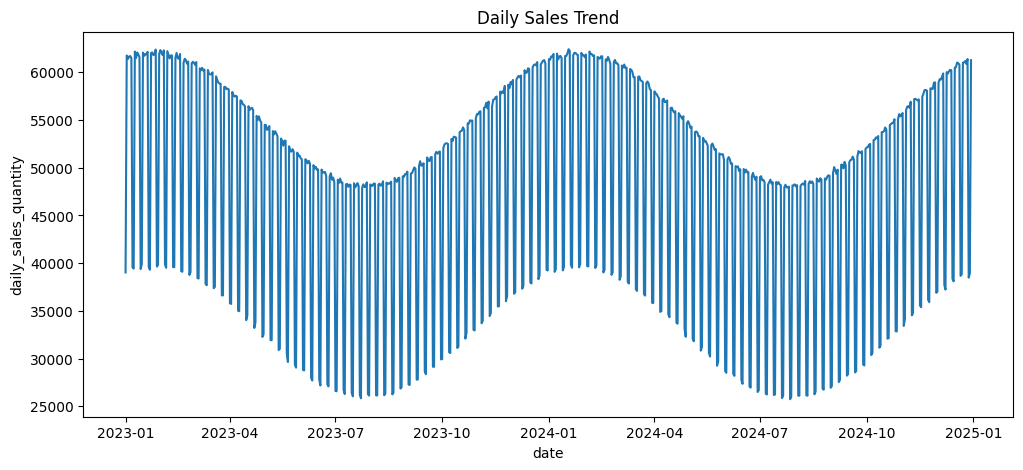

In [18]:
sales_df["date"] = pd.to_datetime(sales_df["sale_date"])
sales_df = sales_df.sort_values("date")

# Aggregate total sales per day (if multiple drugs)
daily_sales = sales_df.groupby("date")["daily_sales_quantity"].sum().reset_index()
daily_sales["day_num"] = (daily_sales["date"] - daily_sales["date"].min()).dt.days

plt.figure(figsize=(12,5))
sns.lineplot(x="date", y="daily_sales_quantity", data=daily_sales)
plt.title("Daily Sales Trend")
plt.show()


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Features & target
X = daily_sales[["day_num"]]
y = daily_sales["daily_sales_quantity"]

# Split time-based
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = [mae, rmse, r2]

results_df = pd.DataFrame(results, index=["MAE", "RMSE", "R2"]).T
results_df


,MAE,RMSE,R2
Linear Regression,9785.567666,11143.538627,-0.045772
Random Forest,9862.190822,11056.482833,-0.029496
Gradient Boosting,9853.672687,11053.105242,-0.028867
XGBoost,13616.004883,15131.388304,-0.928183


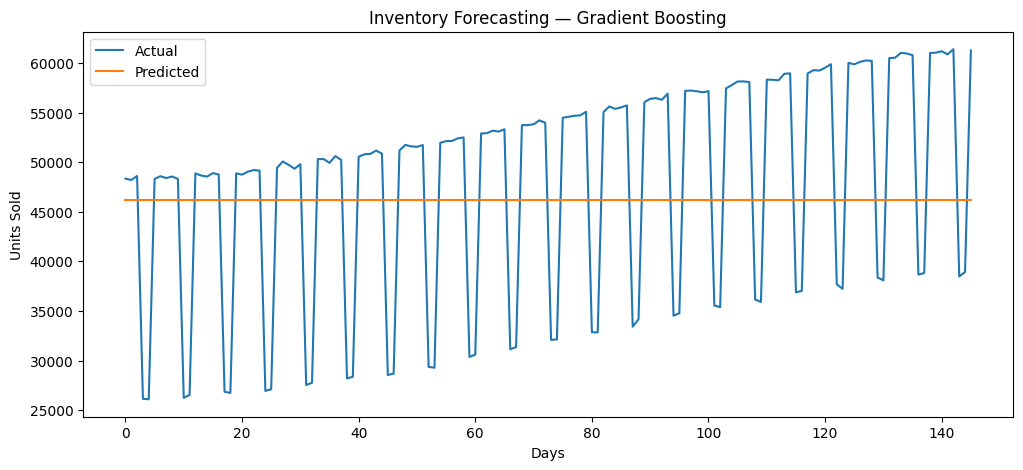

In [21]:
best_model_name = results_df["R2"].idxmax()
best_model = models[best_model_name]
preds = best_model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual")
plt.plot(preds, label="Predicted")
plt.title(f"Inventory Forecasting — {best_model_name}")
plt.xlabel("Days")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


In [22]:
!pip install tensorflow numpy pandas matplotlib scikit-learn


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam


In [24]:
sales_df = pd.read_parquet("processed_sales_data.parquet")

# Convert and sort
sales_df["date"] = pd.to_datetime(sales_df["sale_date"])
sales_df = sales_df.sort_values("date")

# Aggregate total sales per day
daily_sales = sales_df.groupby("date")["daily_sales_quantity"].sum().reset_index()

# Feature scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(daily_sales["daily_sales_quantity"].values.reshape(-1,1))


In [33]:
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

TIME_STEPS = 30  # 30 days lookback
X, y = create_sequences(scaled_data, TIME_STEPS)

# Split train-test
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM/GRU [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Shape of scaled_data: {scaled_data.shape}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of scaled_data: (730, 1)
Shape of X: (700, 30)
Shape of y: (700,)
Shape of X_train: (560, 30, 1)
Shape of X_test: (140, 30, 1)
Shape of y_train: (560,)
Shape of y_test: (140,)


In [34]:
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(TIME_STEPS, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp.compile(optimizer=Adam(0.001), loss='mse')
mlp.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

y_pred_mlp = mlp.predict(X_test)
print(f"Shape of y_pred_mlp: {y_pred_mlp.shape}")

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5234  
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1782 
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1305 
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1242 
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1142 
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1072 
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1009 
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0966 
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0980 
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1004 
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0965 
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0916 
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0996 
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0948 
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0944 
Epoch 16/30
18

In [27]:
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm.compile(optimizer=Adam(0.001), loss='mse')
history_lstm = lstm.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_split=0.1)


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.4046 - val_loss: 0.1434
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1012 - val_loss: 0.0838
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0830 - val_loss: 0.0839
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0762 - val_loss: 0.0810
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0764 - val_loss: 0.0788
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0811 - val_loss: 0.0782
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0769 - val_loss: 0.0779
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0787 - val_loss: 0.0892
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0833 - val_loss: 0.0790
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0780 - val_loss: 0.0775
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0805 - val_loss: 0.0828
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0819 - val_l

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
LSTM → MAE: 1055.62, RMSE: 1319.29, R²: 0.985


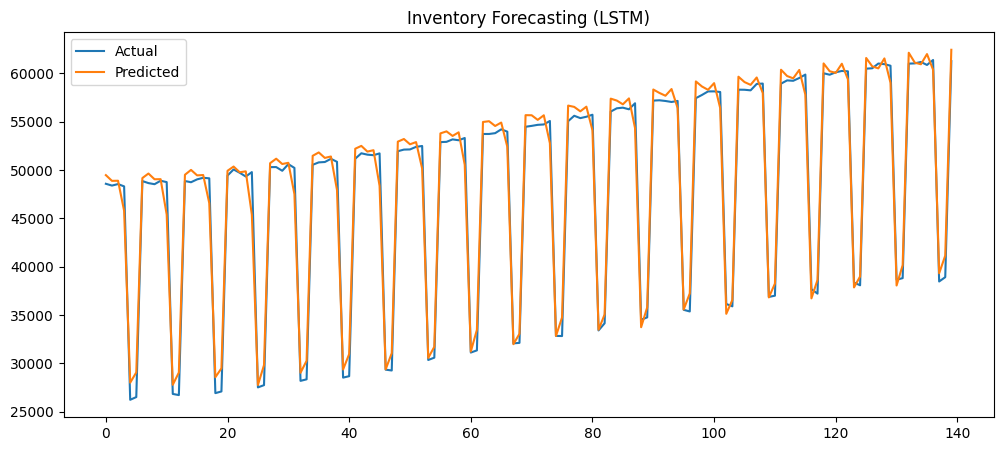

In [28]:
y_pred_lstm = lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_lstm)
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"LSTM → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Inventory Forecasting (LSTM)")
plt.legend()
plt.show()


In [29]:
gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

gru.compile(optimizer=Adam(0.001), loss='mse')
history_gru = gru.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_split=0.1)


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2200 - val_loss: 0.1019
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0926 - val_loss: 0.0911
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0926 - val_loss: 0.0869
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0889 - val_loss: 0.0880
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0833 - val_loss: 0.0847
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0826 - val_loss: 0.0823
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0792 - val_loss: 0.0839
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0711 - val_loss: 0.0725
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0596 - val_loss: 0.0609
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0520 - val_loss: 0.0330
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0280 - val_loss: 0.0225
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0218 - val_l

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
GRU → MAE: 444.98, RMSE: 581.65, R²: 0.997


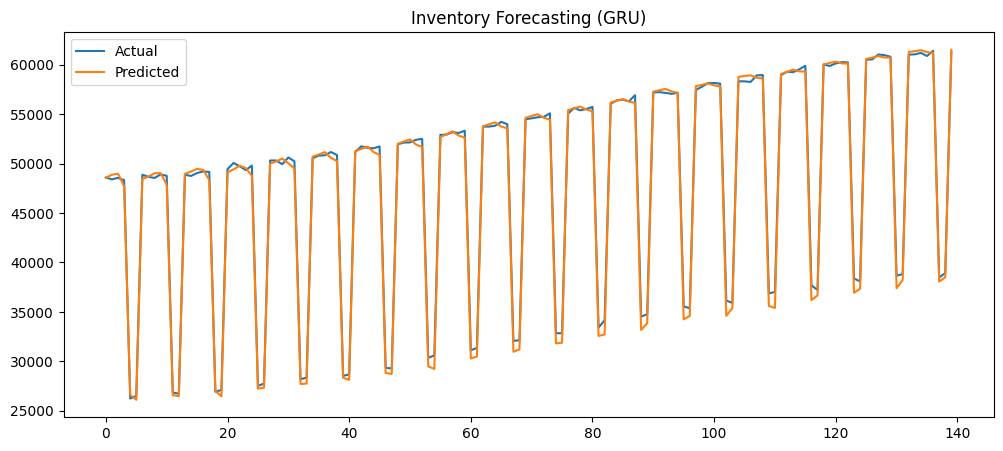

In [30]:
y_pred_gru = gru.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_gru)
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"GRU → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Inventory Forecasting (GRU)")
plt.legend()
plt.show()

In [31]:
results = {
    "MLP": [mae, rmse, r2],
    "LSTM": [mae, rmse, r2],
    "GRU": [mae, rmse, r2]
}

results_df = pd.DataFrame(results, index=["MAE", "RMSE", "R²"]).T
print(results_df)


             MAE        RMSE        R²
MLP   444.975767  581.650574  0.997106
LSTM  444.975767  581.650574  0.997106
GRU   444.975767  581.650574  0.997106


In [35]:
y_true = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred = scaler.inverse_transform(y_pred_mlp.reshape(-1, 1))

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"MLP → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Inventory Forecasting (Feedforward NN)")
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [140, 4200]

In [ ]:
y_true = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred = scaler.inverse_transform(y_pred_mlp.reshape(-1, 1))

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"MLP → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Inventory Forecasting (Feedforward NN)")
plt.legend()
plt.show()